# Mix_up
: data augmentation의 기법의 일종, 두 데이터와 라벨을 일정비율로 섞어 새로운 데이터 생성

: 데이터가 부족할 때 좋다

In [25]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
import torchvision
from torchvision import datasets,transforms

import numpy as np

## Data

In [4]:
# Train
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.AutoAugment(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.3,0.3,0.3))
])


train_dataset = datasets.CIFAR10(root='./CIFAR10_data',
                                 train=True,
                                 download=True,
                                 transform=train_transform)
train_loader = DataLoader(train_dataset,
                          batch_size=64,
                          shuffle=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./CIFAR10_data\cifar-10-python.tar.gz to ./CIFAR10_data


In [5]:
# Test
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.3,0.3,0.3))
])


test_dataset = datasets.CIFAR10(root='./CIFAR10_data',
                                 train=False,
                                 transform=test_transform)
test_loader = DataLoader(test_dataset,
                          batch_size=64,
                          shuffle=True)

## Model


In [2]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(16*32*32, 128)
        self.fc2 = nn.Linear(128,10)


    def forward(self, x):
        x = self.flatten(torch.relu(self.conv1(x)))
        x = self.fc2(self.fc1(x))
        return(x)

In [3]:
model = MyModel()
print(model)

MyModel(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=16384, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


## Set Loss, optimzer 

In [27]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.01)

In [35]:
def Mixup_data(x, y, alpha=1.0):    #x:input, y:target
    batch_size = x.size(0)
    # 무작위 랜덤값 설정 후 0,1 값 사이로 만든다.
    lam = torch.rand(batch_size, 1, 1, 1)
    lam = torch.max(lam, 1-lam)     
    
    """
    lam의 가중치로 x를 곱하고,
    (1-lam) * x.flip(dims=[0,2,3])는 (1-lam)의 가중치로 x를 뒤집은 것을 곱합
    """
    mixed_x = lam*x + (1-lam) * x.flip(dims=[0,2,3])
    indices = torch.randperm(batch_size)    #값은 0부터 batch_size-1까지의 순열

    mixed_y = lam.squeeze()*y + (1-lam.squeeze())*y[indices]
    mixed_y = mixed_y.to(torch.long)

    return mixed_x, mixed_y

### 결과 테스트

In [36]:
"""
x = torch.randn(32, 3, 28, 28)
y = torch.randint(0, 10, (32,))

mixed_x, mixed_y = Mixup_data(x, y)
"""

'\nx = torch.randn(32, 3, 28, 28)\ny = torch.randint(0, 10, (32,))\n\nmixed_x, mixed_y = Mixup_data(x, y)\n'

In [37]:
# y

## Visualize fun

In [38]:
import matplotlib.pyplot as plt
import numpy as np

def plot_images(images, labels, title):
    fig, axes = plt.subplots(2,5, figsize=(12, 6))
    fig.suptitle(title, fontsize=16)
    labels = labels.numpy()

    for i, ax in enumerate(axes.flat):
        image = images[i].squeeze()
        ax.imshow(image, cmap='gray')
        ax.set_title(f"Label: {labels[i]}")
        ax.axis('off')

    plt.show()


## Train loop

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

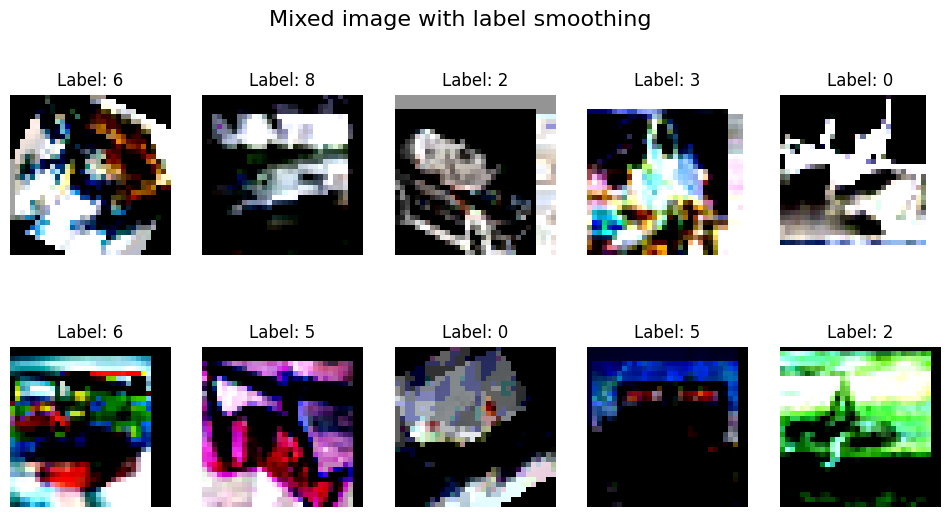

In [40]:
NUM_EPOCHS = 10

train_losses_no_mixup = []
train_losses_mixup = []

idx=  0

for epoch in range(NUM_EPOCHS):
    train_loss_no = 0.0
    train_loss = 0.0

    for inputs, labels in train_loader:
        optimizer.zero_grad()

        # No Mixup
        x, y = inputs, labels

        # MIXUP 실행
        mixed_x, mixed_y = Mixup_data(inputs, labels)

        mixed_images = mixed_x.cpu().numpy()
        mixed_images = np.transpose(mixed_images, (0,2,3,1))
        mixed_images = np.squeeze(mixed_images)

        if idx ==0:
            plot_images(mixed_images, mixed_y.squeeze(), 'Mixed image with label smoothing')
            idx = 1

        #모델 생성
        outputs_no_mixup = model(x)
        outputs_mixup = model(mixed_x)

        labels = torch.squeeze(labels)

        #loss
        loss_no_mixup = criterion(outputs_no_mixup, labels)
        loss_mixup = criterion(outputs_mixup, labels)

        loss_no_mixup.backward()
        loss_mixup.backward()

        #optim
        optimizer.step()

        #loss 계산
        train_loss_no += loss_no_mixup.item()
        train_loss += loss_mixup.item()

    #epoch마다 loss 기록
    train_losses_no_mixup.append(train_loss_no/len(train_loader))
    train_losses_mixup.append(train_loss/len(train_loader))

        

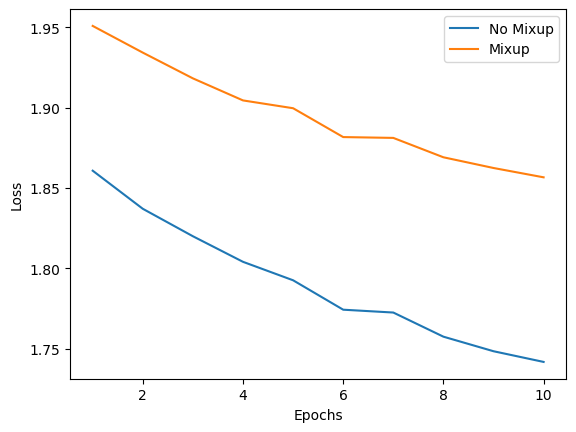

In [41]:
import matplotlib.pyplot as plt

epochs = range(1, NUM_EPOCHS+1)

plt.plot(epochs, train_losses_no_mixup, label='No Mixup')
plt.plot(epochs, train_losses_mixup, label='Mixup')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()